In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

# Get data

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [5]:
IMG_SIZE=224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manualy created transforms: {manual_transforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
type(manual_transforms)

torchvision.transforms.transforms.Compose

In [7]:
# Dataloader for images
BATCH_SIZE = 32  # Higher number of batch size, the more computation power is needed

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir, 
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa067f8bf90>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

# Eq 1: Split the data into patches, then creating the class, position, and patch embedding. 

### 1. Calculating patch embedding input and output shapes

In [9]:
# Create example values
height = 224        # height
width = 224         # width
color_channels = 3  # channel 
patch_size = 16     # P

# Calculate N (num of patches)
num_of_patches = int((height * width) / patch_size**2)
print(f'Num of patch (N) with image height (G={height}), width (W={width}), and patch size (P={patch_size}): {num_of_patches} ')


Num of patch (N) with image height (G=224), width (W=224), and patch size (P=16): 196 


In [10]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f'input: {embedding_layer_input_shape}')
print(f'output: {embedding_layer_output_shape}')

input: (224, 224, 3)
output: (196, 768)


### 2. Convert an image into patches 

(-0.5, 223.5, 223.5, -0.5)

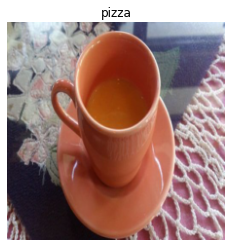

In [11]:
# view the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

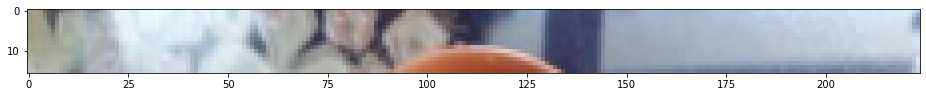

In [12]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

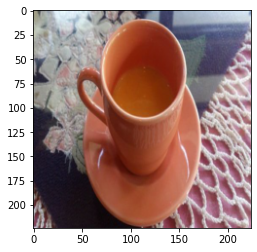

In [13]:
plt.imshow(image_permuted)

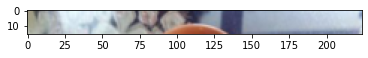

In [14]:
plt.imshow(image_permuted[:16, :, :])

Num of patches per row: 14.0
Patch size: 16 * 16


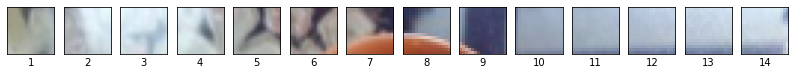

In [15]:
# Setup hyperparameters and make sure image_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patchs = img_size / patch_size
assert img_size % patch_size == 0
print(f'Num of patches per row: {num_patchs}\nPatch size: {patch_size} * {patch_size}')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patchs, num_patchs),
                        sharex=True,
                        sharey=True)

# Iterate through num of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Num of patches per row: 14.0        
Num of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 * 16


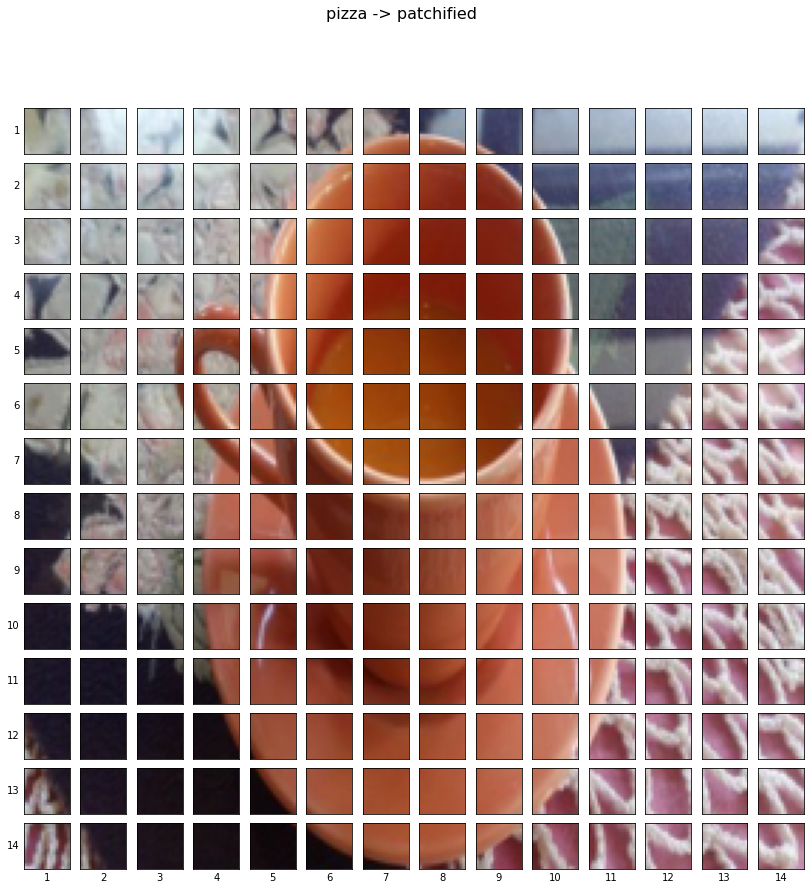

In [19]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f'Num of patches per row: {num_patches}\
        \nNum of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} * {patch_size}')

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of img
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted img patch (img_permuted ->(height, width, channel))
        axs[i, j].imshow(image_permuted[patch_height: patch_height+patch_size,
                                        patch_width: patch_width+patch_size,
                                        :])
        
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=16)
plt.show()

### 3. Creating image patches with torch.nn.Conv2d()